## Results of point pollution surface oil spill scenarios in the Strait of Juan de Fuca
Bulker Loss of Power as vessels leaves *Johnson Strait*, gets pushed on the shore before tug arrives on scene, spilling 1000 m<sup>-3</sup> of Bunker C. Scenario built on incident ROC report 323, 2020.
- *the description provided by the team stated this location, which we assumed should really say Jonhstone Strait, but the coordinates provided were in Juan de Fuca Strait, so Atlantis scenarios are based in Juan de Fuca*

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
affected_boxes = [1, 2]

### Define scenario and control files

In [3]:
hex_colour = '#A27170'
hatches = ['oo', '///', 'xx', '++']

In [4]:
# Oil injection file 
oil_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/')
oil_paths = sorted([p for p in oil_root.glob('SSAM_Scenario_7a*_10000_alkyls.nc')])
oil_files = [xr.open_dataset(oil_scen,decode_cf=True) for oil_scen in oil_paths]

In [5]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI1')

control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Control/highres-control-3y-2019-2022/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'])


In [6]:
scenario_paths = sorted([p for p in scenario_root.glob('highres-2019-2022_7a*/outputSalishSea.nc')])
for path in scenario_paths:
    print(path.parent.stem, groups.conditions[str(path.parent.stem).split(sep = '_')[3]])

highres-2019-2022_7a_1_2019-01-21 low Fraser flow spring tide winter
highres-2019-2022_7a_2_2019-01-26 low Fraser flow neap tide winter
highres-2019-2022_7a_3_2020-01-11 high Fraser flow spring tide winter
highres-2019-2022_7a_4_2020-01-03 high Fraser flow neap tide winter


In [7]:
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [8]:
# start and end time of data display, after burn-in
start = 0
end = time.size-1

In [9]:
# Reading in Atlantis map
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
jdf_df = data_df.loc[data_df.Region=='Juan de Fuca']
hs_df = data_df.loc[data_df.Region=='Howe Sound']
strait_df = data_df.loc[data_df.Region=='Strait of Georgia']
ps_df = data_df.loc[data_df.Region=='Puget Sound']

### Mapping spill extent

JF-1 BOX_ID
1    655575973
Name: AREA, dtype: int64
JF-2 BOX_ID
0     97362056
1    655575973
Name: AREA, dtype: int64
JF-4 BOX_ID
1    655575973
Name: AREA, dtype: int64
JF-3 BOX_ID
1    655575973
2    682702420
Name: AREA, dtype: int64


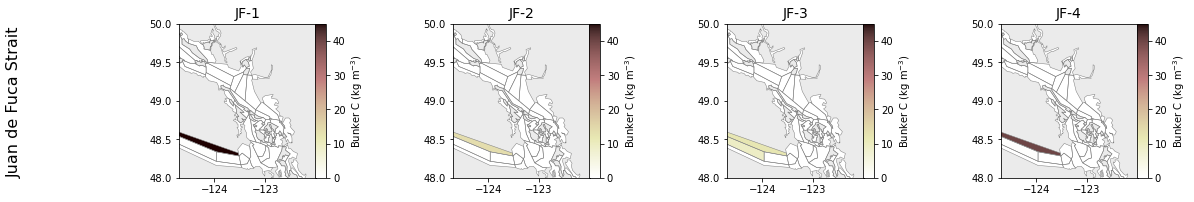

In [10]:
fig = plt.figure(figsize=(18, 6), facecolor='white') #figsize=(9, 12)
gs = plt.GridSpec(1, len(oil_files), wspace=0.5, hspace=0.2, height_ratios=[1],)

for file, oil_path in zip(oil_files, oil_paths):
    date = str(oil_path).split(sep = '_')[3]
    label = 'JF-'+ str(groups.simulations[groups.conditions[date]])
    position = int(str(groups.simulations[groups.conditions[date]]))-1
    oil_tb = file.variables['oil']
    oil_b = oil_tb.mean(axis=0)

    # Add scenario data to Atlantis spatial data
    data_df['oil'] = oil_b
    data_df.loc[land_boxes, 'oil'] = 0
    oil_df = data_df.loc[data_df['oil'] > 2.5] #5% of maximum
    print(label,oil_df.AREA)

    ax = fig.add_subplot(gs[0, position], facecolor = '#EBEBEB')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=-0.5)
    ax = data_df.plot(column = 'oil', ax=ax, cax=cax,cmap=cm.pink_r, legend_kwds={'label': 'Bunker C (kg m$^{-3}$)'}, vmax=45,
    #ax = data_df.plot(column = 'BOTZ', ax=ax, cax=cax,cmap=cm.Blues, legend_kwds={'label': 'depth (m)'},
    legend=True, 
    )
    ax.set_title(label, fontsize = 14) #loc='left'
    ax.set_xlim(-124.7)
    ax.set_ylim(48, 50)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.5)
    land_df.plot(ax=ax, color='#EBEBEB')
    #oil_df.plot(ax=ax, color='red',linewidths=0.5)
fig.supylabel('Juan de Fuca Strait', fontsize = 16); #color=hex_colour
fig.savefig("Figures/spill-map-JF.png", dpi=300, bbox_inches='tight')

### Oil injection

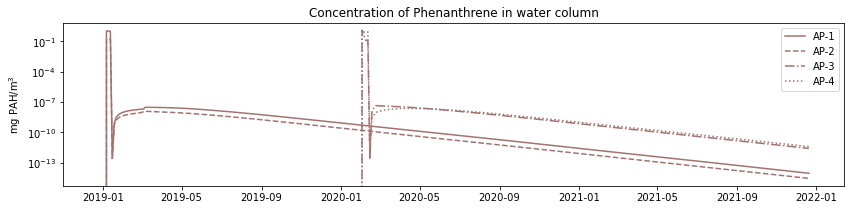

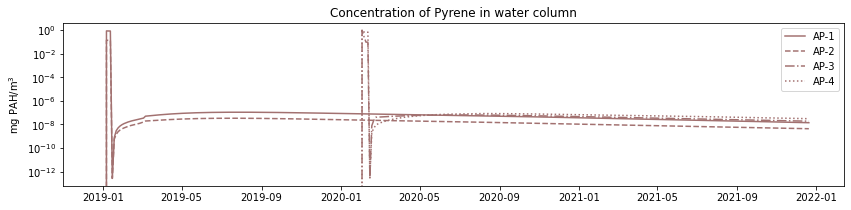

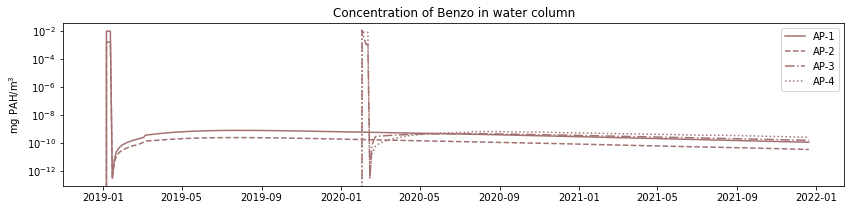

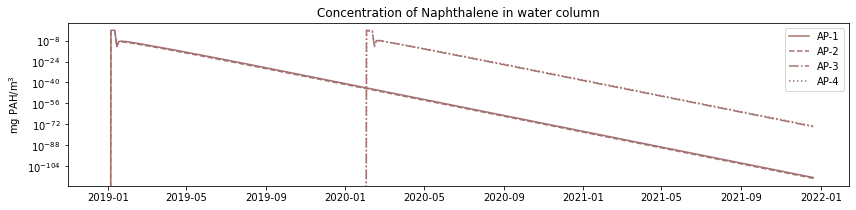

In [11]:
for pah in groups.pahs:
  fig, ax = plt.subplots(figsize = (14,3))
  names = []
  line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))
  for scenario, path, i in zip(scenario_datasets,scenario_paths,range(0,len(scenario_datasets))):
      nm = path.parent.stem.split(sep = '_')
      names.append('AP-'+str(nm[2]))
      contam_tbl = scenario.variables[str(pah)][start:end,:,0:6]
      contam_tb = contam_tbl.sum(axis=2)
      contam_t = contam_tb.sum(axis=1)
      ax.semilogy(scenario.t[start:end], contam_t, color=hex_colour, linestyle=next(line_styles))
  ax.set_title('Concentration of '+ pah +' in water column', fontsize = 12)
  ax.set_ylabel('mg PAH/m$^3$')
  ax.legend(names, loc='best')

## Results

In [12]:
def plot_pelagic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1,1,1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])
        #bio_index = (list(bio_group).index(species))
        #ax = fig.add_subplot(gs[bio_index])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'AP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [13]:
def plot_vertebrate_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1,1,1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        c_numbers_tbl = np.ma.filled(control.variables[bio_group[species] + '3_Nums'][:, boxes, 0:6], np.nan)
        c_structuralN_tbl = np.ma.filled(control.variables[bio_group[species] +'3_StructN'][:, boxes, 0:6], np.nan)
        c_reservedN_tbl = np.ma.filled(control.variables[bio_group[species] +'3_ResN'][:, boxes, 0:6], np.nan)
        c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
        c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))

        ax.plot(control.t, c_weightatage_t, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'AP-'+nm[2]  
            names.append(scenario_name)
 
            o_numbers_tbl = np.ma.filled(scenario.variables[bio_group[species] + '3_Nums'][:, boxes, 0:6], np.nan)
            o_structuralN_tbl = np.ma.filled(scenario.variables[bio_group[species] +'3_StructN'][:, boxes, 0:6], np.nan)
            o_reservedN_tbl = np.ma.filled(scenario.variables[bio_group[species] +'3_ResN'][:, boxes, 0:6], np.nan)
            o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
            o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))
            
            ax.plot(scenario.t, o_weightatage_t, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
       
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [14]:
def plot_benthic_biomass(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1,1,1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        ax.plot(control.t, pelagic_control, 'k')
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'JF-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(scenario.t, pelagic_oiled, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        
        ax.set_ylabel('Biomass', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

In [15]:
def plot_groups_benthic_N(bio_group, scenario_datasets, scenario_paths, control=control, boxes=groups.salish_sea, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], )
    line_styles = itertools.cycle(('-', '--', '-.', ':',(5, (10, 3)),
    (0, (3, 1, 1, 1)),(0, (1, 1)),(0, (3, 10, 1, 10, 1, 10))))

    for species in bio_group:
        names = ['control']
        bio_index = (list(bio_group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][:,boxes], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(control.t, control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets, scenario_paths):
            nm = str(path.parent.stem).split(sep='_')
            scenario_name = 'AP-'+nm[2]  
            names.append(scenario_name)

            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][:,boxes], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(scenario.t, ratio, linewidth = 2, color=hex_colour, linestyle=next(line_styles))
        ax.fill_between(scenario.t, -groups.sensitivity[species], groups.sensitivity[species],
            color='grey', alpha=0.3, label='Model threshold')
       
        ax.set_ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, fontsize=12); #bbox_to_anchor=(1.05, 1)

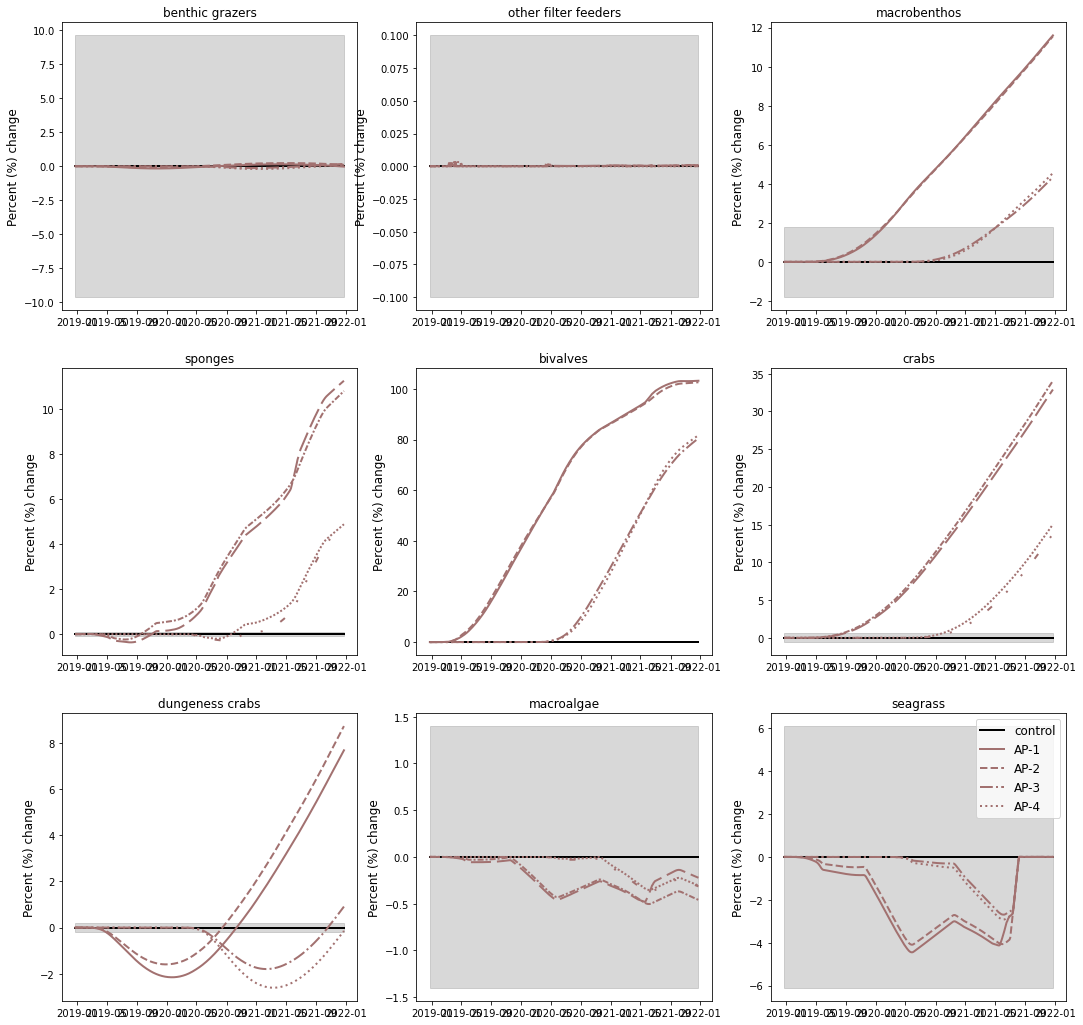

In [16]:
plot_groups_benthic_N(groups.benthos, scenario_datasets, scenario_paths, control=control, boxes=affected_boxes)

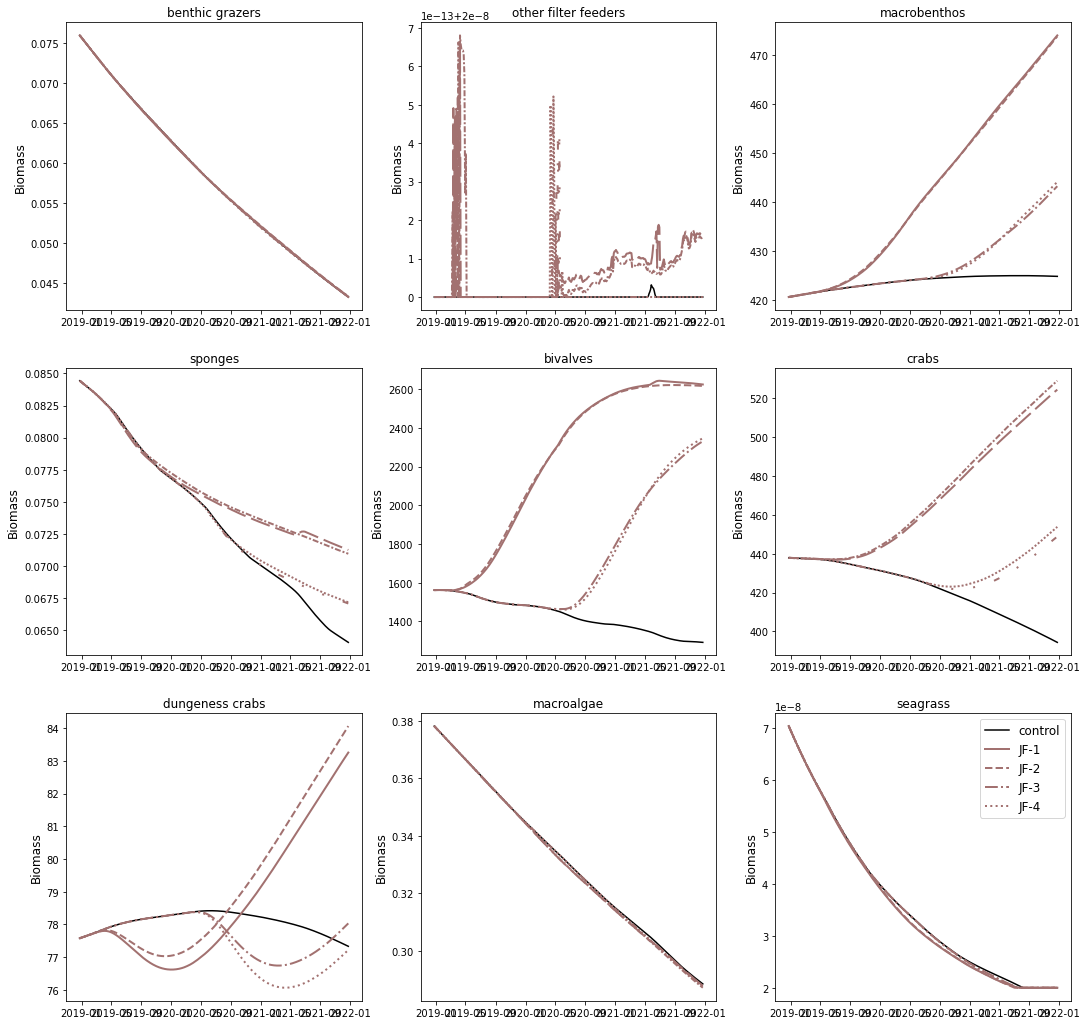

In [17]:
plot_benthic_biomass(groups.benthos, scenario_datasets, scenario_paths, boxes=affected_boxes)

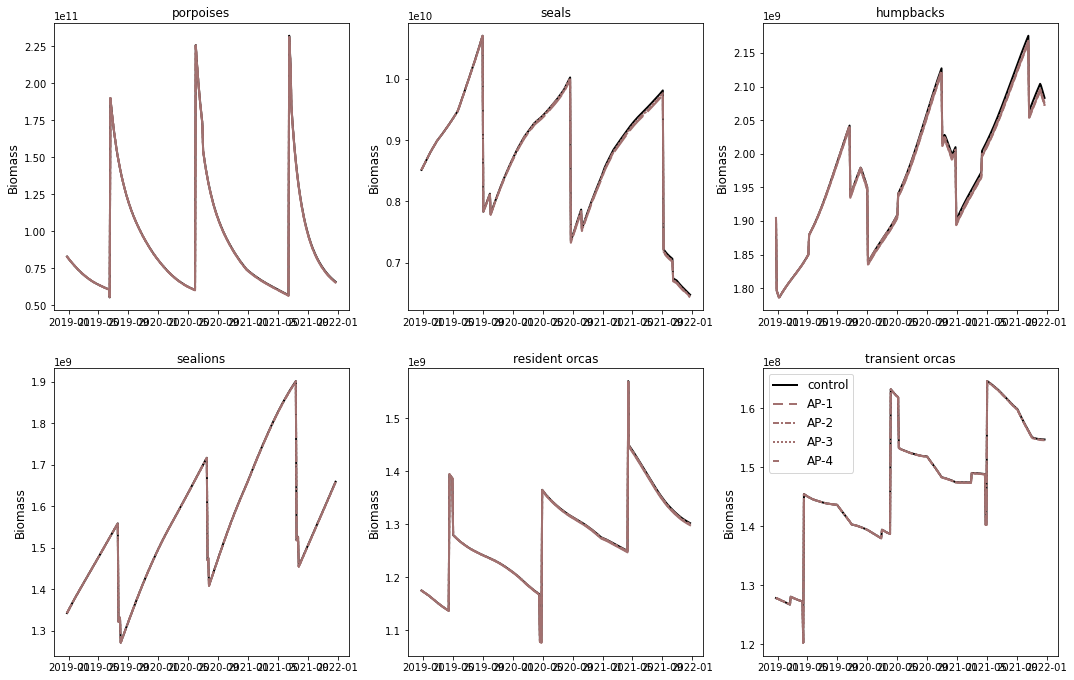

In [18]:
plot_vertebrate_biomass(groups.mammals, scenario_datasets, scenario_paths, boxes=affected_boxes)